<a href="https://colab.research.google.com/github/supuni9622/Test-Google-Colab/blob/main/Tensorflow_Lyrics_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
cd /content/drive/MyDrive/4th Year Research/M3/Test Implementation/Test-Google-Colab/TestV2/Tensorflow

/content/drive/MyDrive/4th Year Research/M3/Test Implementation/Test-Google-Colab/TestV2/Tensorflow


In [16]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [17]:
df = pd.read_csv('Lyrical_data_5.csv',encoding='cp1252')
df.shape

(800, 4)

In [18]:
df.head()

,Song_ID,Song_Title,Chorus,Emotion
0,1,Diana,"Diana,\rLet me be the one to light a fire insi...",Inspiration
1,2,Don't forget where you belong,Don't forget where you belong\rHome\rDon't for...,Inspiration
2,3,Strong,"I'm sorry if I say, ""I need you""\nBut I don't ...",Inspiration
3,4,Happily,I don't care what people say when we're togeth...,Love
4,5,Better than words,Better than words\rMore than a feeling Crazy i...,Love


In [19]:
df = df.dropna(how="any").reset_index(drop=True)

Preprocessing

In [20]:
from numpy import random
import gensim
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string

REPLACE = re.compile('[^a-zA-Z]')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
translator = str.maketrans("", "", string.punctuation)

def clean_text(text):

    text = text.lower() # lowercase text
    text = REPLACE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    text = text.translate(translator)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
df["Chorus"] = df.Chorus.map(clean_text)
df.head()

,Song_ID,Song_Title,Chorus,Emotion
0,1,Diana,diana let one light fire inside eyes lonely ev...,Inspiration
1,2,Don't forget where you belong,forget belong home forget belong home ever fee...,Inspiration
2,3,Strong,sorry say need care scared love cause weaker w...,Inspiration
3,4,Happily,care people say together know wanna one hold s...,Love
4,5,Better than words,better words feeling crazy love dancing ceilin...,Love


In [53]:
possible_labels = df.Emotion.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Angry': 4, 'Calm': 3, 'Happy': 5, 'Inspiration': 0, 'Love': 1, 'Sad': 2}

In [54]:
df['Emotion'] = df.Emotion.replace(label_dict)
df.head()

,Song_ID,Song_Title,Chorus,Emotion
0,1,Diana,diana let one light fire inside eyes lonely ev...,0
1,2,Don't forget where you belong,forget belong home forget belong home ever fee...,0
2,3,Strong,sorry say need care scared love cause weaker w...,0
3,4,Happily,care people say together know wanna one hold s...,1
4,5,Better than words,better words feeling crazy love dancing ceilin...,1


In [55]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.Chorus)
print(counter)
print("Length", len(counter))

Counter({'love': 437, 'know': 322, 'like': 276, 'let': 204, 'go': 194, 'never': 184, 'oh': 183, 'get': 179, 'baby': 176, 'time': 169, 'one': 165, 'say': 160, 'need': 157, 'wanna': 157, 'got': 156, 'cause': 155, 'see': 153, 'want': 146, 'heart': 144, 'yeah': 142, 'feel': 141, 'gonna': 138, 'life': 134, 'way': 133, 'take': 128, 'come': 124, 'away': 116, 'make': 115, 'every': 115, 'give': 106, 'night': 103, 'right': 102, 'could': 102, 'still': 96, 'back': 89, 'keep': 86, 'tell': 84, 'think': 83, 'alone': 82, 'good': 81, 'world': 80, 'everything': 80, 'little': 79, 'day': 77, 'hold': 69, 'said': 69, 'find': 66, 'leave': 64, 'better': 64, 'try': 64, 'dance': 64, 'ever': 63, 'mind': 63, 'eyes': 60, 'die': 60, 'would': 60, 'sing': 59, 'live': 59, 'even': 58, 'look': 58, 'always': 58, 'things': 57, 'light': 56, 'feeling': 56, 'call': 56, 'home': 55, 'well': 55, 'lonely': 53, 'girl': 53, 'head': 53, 'put': 52, 'tonight': 52, 'us': 52, 'nothing': 51, 'lost': 50, 'gone': 50, 'made': 49, 'pain': 4

In [56]:
counter.most_common(10)

[('love', 437),
 ('know', 322),
 ('like', 276),
 ('let', 204),
 ('go', 194),
 ('never', 184),
 ('oh', 183),
 ('get', 179),
 ('baby', 176),
 ('time', 169)]

In [57]:
num_unique_words = len(counter)

Stratification - Dealing with inbalanced data set

In [58]:
def get_class_counts(dataframe):
  grp = dataframe.groupby(['Emotion'])['Song_ID'].nunique()
  return {key:grp[key] for key in list(grp.keys())}

def get_class_proportions(dataframe):
  class_counts = get_class_counts(dataframe)
  return {val[0]: round(val[1]/dataframe.shape[0], 4) for val in class_counts.items()}

print("Dataset class counts", get_class_counts(df))
print("Dataset class proportions", get_class_proportions(df))

Dataset class counts {0: 149, 1: 146, 2: 213, 3: 88, 4: 71, 5: 133}
Dataset class proportions {0: 0.1862, 1: 0.1825, 2: 0.2662, 3: 0.11, 4: 0.0888, 5: 0.1662}


In [59]:
from sklearn.model_selection import train_test_split

train_, test_ = train_test_split(df, test_size=0.2)

train_class_proportions = get_class_proportions(train_)
test_class_proportions = get_class_proportions(test_)

print("Train data class proportions", train_class_proportions)
print("Test data class proportions", test_class_proportions)

train_stratify, test_stratify = train_test_split(df, test_size=0.2, stratify=df['Emotion'])

train_class_proportions_stratify = get_class_proportions(train_stratify)
test_class_proportions_stratify = get_class_proportions(test_stratify)

print("Train data class proportions after stratifying", train_class_proportions_stratify)
print("Test data class proportions after stratifying", test_class_proportions_stratify)

Train data class proportions {0: 0.1875, 1: 0.1781, 2: 0.2719, 3: 0.1078, 4: 0.0906, 5: 0.1641}
Test data class proportions {0: 0.1812, 1: 0.2, 2: 0.2438, 3: 0.1188, 4: 0.0812, 5: 0.175}
Train data class proportions after stratifying {0: 0.1859, 1: 0.1828, 2: 0.2656, 3: 0.1109, 4: 0.0891, 5: 0.1656}
Test data class proportions after stratifying {0: 0.1875, 1: 0.1812, 2: 0.2688, 3: 0.1062, 4: 0.0875, 5: 0.1688}


In [60]:
# split text and labels
train_sentences = train_stratify.Chorus.to_numpy()
train_labels = train_stratify.Emotion.to_numpy()
val_sentences = test_stratify.Chorus.to_numpy()
val_labels = test_stratify.Emotion.to_numpy()

In [61]:
train_sentences.shape, val_sentences.shape

((640,), (160,))

In [62]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [63]:
# each word has unique index
word_index = tokenizer.word_index
print(word_index)

{'love': 1, 'know': 2, 'like': 3, 'go': 4, 'oh': 5, 'let': 6, 'get': 7, 'baby': 8, 'never': 9, 'say': 10, 'see': 11, 'wanna': 12, 'one': 13, 'time': 14, 'need': 15, 'got': 16, 'cause': 17, 'want': 18, 'heart': 19, 'way': 20, 'life': 21, 'feel': 22, 'yeah': 23, 'come': 24, 'gonna': 25, 'take': 26, 'every': 27, 'make': 28, 'give': 29, 'away': 30, 'right': 31, 'still': 32, 'night': 33, 'back': 34, 'keep': 35, 'world': 36, 'could': 37, 'little': 38, 'tell': 39, 'think': 40, 'alone': 41, 'day': 42, 'everything': 43, 'dance': 44, 'said': 45, 'good': 46, 'try': 47, 'ever': 48, 'sing': 49, 'mind': 50, 'hold': 51, 'leave': 52, 'live': 53, 'find': 54, 'home': 55, 'even': 56, 'eyes': 57, 'things': 58, 'always': 59, 'well': 60, 'better': 61, 'put': 62, 'head': 63, 'tonight': 64, 'us': 65, 'light': 66, 'call': 67, 'feeling': 68, 'die': 69, 'girl': 70, 'song': 71, 'look': 72, 'lost': 73, 'lonely': 74, 'would': 75, 'place': 76, 'bad': 77, 'something': 78, 'inside': 79, 'hate': 80, 'around': 81, 'real

In [64]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [65]:
print(train_sentences[10:15])
print(train_sequences[10:15])

['never miss beat lightning feet see see dancing make moves go know know shake'
 'memory feeling way blood rushes fingers movies cause lies issues cause mine every movement way shiver twist hair end fingers young daylight dream gone music meets song fell right wrong would come back one last song'
 'skies blue tides high see moon think swim circles mind acting like muse paint picture head make silhouettes like poems never read write bed like love love love love'
 'keep coming back coming back keep running round running round running round head certain things adore certain certain certain something get angry mercy like shoulder turn cause certain things mend us hanging dear life held tight'
 'mess talking shit gonna push away say love make crazy go go look look eye really going away without fight reasoned done polite told one two three four five si thousand times made obvious made clear want spell f r e n made obvious made clear want spell f r e n f r e n']
[[9, 139, 211, 1612, 703, 11, 

In [66]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((640, 20), (160, 20))

In [67]:
train_padded[10]

array([   9,  139,  211, 1612,  703,   11,   11,  131,   28,  891,    4,
          2,    2,  263,    0,    0,    0,    0,    0,    0], dtype=int32)

In [68]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

never miss beat lightning feet see see dancing make moves go know know shake
[9, 139, 211, 1612, 703, 11, 11, 131, 28, 891, 4, 2, 2, 263]
[   9  139  211 1612  703   11   11  131   28  891    4    2    2  263
    0    0    0    0    0    0]


In [69]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
print(reverse_word_index)

{1: 'love', 2: 'know', 3: 'like', 4: 'go', 5: 'oh', 6: 'let', 7: 'get', 8: 'baby', 9: 'never', 10: 'say', 11: 'see', 12: 'wanna', 13: 'one', 14: 'time', 15: 'need', 16: 'got', 17: 'cause', 18: 'want', 19: 'heart', 20: 'way', 21: 'life', 22: 'feel', 23: 'yeah', 24: 'come', 25: 'gonna', 26: 'take', 27: 'every', 28: 'make', 29: 'give', 30: 'away', 31: 'right', 32: 'still', 33: 'night', 34: 'back', 35: 'keep', 36: 'world', 37: 'could', 38: 'little', 39: 'tell', 40: 'think', 41: 'alone', 42: 'day', 43: 'everything', 44: 'dance', 45: 'said', 46: 'good', 47: 'try', 48: 'ever', 49: 'sing', 50: 'mind', 51: 'hold', 52: 'leave', 53: 'live', 54: 'find', 55: 'home', 56: 'even', 57: 'eyes', 58: 'things', 59: 'always', 60: 'well', 61: 'better', 62: 'put', 63: 'head', 64: 'tonight', 65: 'us', 66: 'light', 67: 'call', 68: 'feeling', 69: 'die', 70: 'girl', 71: 'song', 72: 'look', 73: 'lost', 74: 'lonely', 75: 'would', 76: 'place', 77: 'bad', 78: 'something', 79: 'inside', 80: 'hate', 81: 'around', 82: '

In [70]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [71]:
decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[9, 139, 211, 1612, 703, 11, 11, 131, 28, 891, 4, 2, 2, 263]
never miss beat lightning feet see see dancing make moves go know know shake


In [89]:
# Create LSTM model
from tensorflow.keras import layers

# Embedding: https://www.tensorflow.org/tutorials/text/word_embeddings
# Turns positive integers (indexes) into dense vectors of fixed size. (other approach could be one-hot-encoding)

# Word embeddings give us a way to use an efficient, dense representation in which similar words have 
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify).

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))


# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.


model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(6, activation="sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 32)            112224    
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 137,446
Trainable params: 137,446
Non-trainable params: 0
_________________________________________________________________


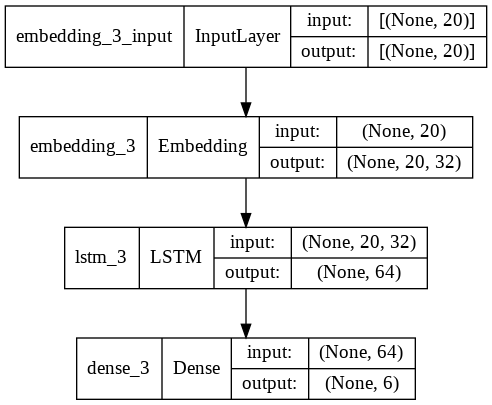

In [97]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'model.png', show_shapes=True)

In [90]:
loss = keras.losses.SparseCategoricalCrossentropy()
optim = keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [108]:
history = model.fit(
    train_padded, 
    train_labels, 
    epochs=100,
    validation_data=(val_padded, val_labels), 
    validation_split=0.2,
    verbose=2)

Epoch 1/100
16/16 - 0s - loss: 0.0206 - accuracy: 0.9961 - val_loss: 1.3807 - val_accuracy: 0.7500 - 238ms/epoch - 15ms/step
Epoch 2/100
16/16 - 0s - loss: 0.0129 - accuracy: 0.9961 - val_loss: 1.3566 - val_accuracy: 0.7500 - 219ms/epoch - 14ms/step
Epoch 3/100
16/16 - 0s - loss: 0.0141 - accuracy: 0.9980 - val_loss: 1.3823 - val_accuracy: 0.7500 - 211ms/epoch - 13ms/step
Epoch 4/100
16/16 - 0s - loss: 0.0146 - accuracy: 0.9980 - val_loss: 1.4000 - val_accuracy: 0.7422 - 204ms/epoch - 13ms/step
Epoch 5/100
16/16 - 0s - loss: 0.0133 - accuracy: 0.9961 - val_loss: 1.3988 - val_accuracy: 0.7422 - 220ms/epoch - 14ms/step
Epoch 6/100
16/16 - 0s - loss: 0.0129 - accuracy: 0.9980 - val_loss: 1.3973 - val_accuracy: 0.7422 - 219ms/epoch - 14ms/step
Epoch 7/100
16/16 - 0s - loss: 0.0109 - accuracy: 0.9980 - val_loss: 1.4066 - val_accuracy: 0.7422 - 226ms/epoch - 14ms/step
Epoch 8/100
16/16 - 0s - loss: 0.0136 - accuracy: 0.9980 - val_loss: 1.4120 - val_accuracy: 0.7500 - 223ms/epoch - 14ms/step


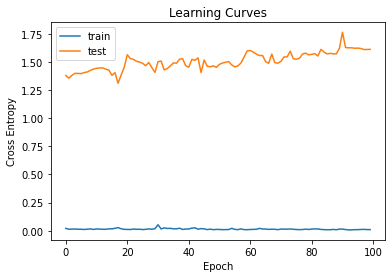

In [109]:
from matplotlib import pyplot
# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

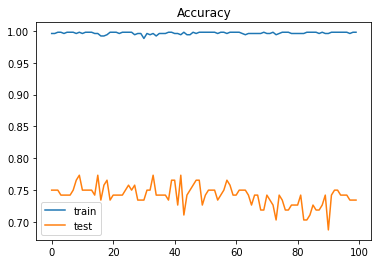

In [110]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [113]:
accr = model.evaluate(train_padded, train_labels)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20/20 [==============================] - 0s 5ms/step - loss: 0.3295 - accuracy: 0.9453
Test set
  Loss: 0.330
  Accuracy: 0.945


In [93]:
predictions = model.predict(train_padded)
#predictions = [1 if p > 0.5 else 0 for p in predictions]

In [96]:
print(train_sentences[10:15])

print(train_labels[10:15])
print(predictions[10:15])

['never miss beat lightning feet see see dancing make moves go know know shake'
 'memory feeling way blood rushes fingers movies cause lies issues cause mine every movement way shiver twist hair end fingers young daylight dream gone music meets song fell right wrong would come back one last song'
 'skies blue tides high see moon think swim circles mind acting like muse paint picture head make silhouettes like poems never read write bed like love love love love'
 'keep coming back coming back keep running round running round running round head certain things adore certain certain certain something get angry mercy like shoulder turn cause certain things mend us hanging dear life held tight'
 'mess talking shit gonna push away say love make crazy go go look look eye really going away without fight reasoned done polite told one two three four five si thousand times made obvious made clear want spell f r e n made obvious made clear want spell f r e n f r e n']
[5 2 1 2 4]
[[0.8496495  0.056